In [1]:
# This branch of qiskit is required:  pip install git+https://github.com/LNoorl/qiskit-terra.git@feature/sk-pass

import numpy as np
import dreamcoder as dc
from dreamcoder.domains.quantum_circuits.primitives import *
from dreamcoder.domains.quantum_circuits.tasks import *
import dill as pickle 
import time
from tqdm import trange
import random
import bin.binutil
import datetime
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def get_primitive_arguments(tp, arguments,last_qubit=0):
    if len(tp.arguments)!=0:
        if tp.arguments[0].name=="int":
            arguments.append(last_qubit)
            last_qubit+=1
        elif tp.arguments[0].name=="tcircuit":
            arguments.append(["no_op"])
        return get_primitive_arguments(tp.arguments[1], arguments, last_qubit)
    
    else:
        for i in range(len(arguments)):
            if type(arguments[i]) == list:
                arguments[i] = no_op(last_qubit)
        return arguments
    

def lb(s,T=20):
    s = s.split()
    l = []
    n = 0
    for w in s:
        if n + len(w) > T:
            l.append("<br />")
            n = 0
        n += len(w)
        l.append(w)
    return " ".join(l)

def get_program_children(program):
    try:
        return {k: getName(k) for _,k in program.body.walk() if k.isInvented}
    except:
        return {k: getName(k) for _,k in program.walk() if k.isInvented}

def get_program_simplification(program):
    if program in name: return name[program]
    children = get_program_children(program)
    simplification_ = program
    for k,childName in children.items():
        simplification_ = simplification_.substitute(k, dc.program.Primitive(childName,ty=None,value=None))
    return simplification_    
    
def getName(program):
    if program in name: return name[program]
    children = get_program_children(program)
    simplification_ = get_program_simplification(program.body)
    # for original, simplified in nameSimplification.items():
    #     simplification_ = simplification_.substitute(Primitive(original,None,None),
    #                                                     Primitive(simplified,None,None))
    name[program] = "f%d"%len(name)
    simplification[program] = simplification_
    depth[program] = 1 + max([depth[k] for k in children] + [0])
    return name[program]

def get_primitive_lambda(n_qubit, operation_name):
    if n_qubit==1:
        return lambda old_circuit, q: n_qubit_gate(old_circuit, q, operation_name=operation_name)
    elif n_qubit==2:
        return lambda old_circuit, q1, q2: n_qubit_gate(old_circuit, q1, q2, operation_name=operation_name)
    elif n_qubit==3:
        return lambda old_circuit, q1, q2,q3: n_qubit_gate(old_circuit, q1, q2, q3, operation_name=operation_name) 
    elif n_qubit==4:
        return lambda old_circuit, q1, q2,q3,q4: n_qubit_gate(old_circuit, q1, q2, q3,q4, operation_name=operation_name) 
    elif n_qubit==5:
        return lambda old_circuit, q1, q2,q3,q4,q5: n_qubit_gate(old_circuit, q1, q2, q3,q4,q5, operation_name=operation_name)       
    elif n_qubit==6:
        return lambda old_circuit, q1, q2,q3,q4,q5, q6: n_qubit_gate(old_circuit, q1, q2, q3,q4,q5,q6, operation_name=operation_name)  
    elif n_qubit==7:
        raise Exception("ask Kevin.")     
    
def get_qk_lambda(n_qubit, gate):
    if n_qubit==1:
        return lambda QT,q1: QT.circuit.append(gate, (QT.q(q1),))
    elif n_qubit==2:
        return lambda QT, q1,q2: QT.circuit.append(gate, (QT.q(q1), QT.q(q2)))
    elif n_qubit==3:
        return lambda QT, q1,q2,q3: QT.circuit.append(gate, (QT.q(q1), QT.q(q2), QT.q(q3)))
    elif n_qubit==4:
        return lambda QT, q1,q2,q3,q4: QT.circuit.append(gate, (QT.q(q1), QT.q(q2), QT.q(q3), QT.q(q4)))
    elif n_qubit==5:
        return lambda QT, q1,q2,q3,q4,q5: QT.circuit.append(gate, (QT.q(q1), QT.q(q2), QT.q(q3), QT.q(q4),QT.q(q5)))
    elif n_qubit==6:
        return lambda QT, q1,q2,q3,q4,q5,q6: QT.circuit.append(gate, (QT.q(q1), QT.q(q2), QT.q(q3), QT.q(q4),QT.q(q5),QT.q(q6)))
    elif n_qubit==7:
        raise Exception("ask Kevin.") 
    
def f_circuit(circuit_unitary, *qubit, circuit_template):
    print(circuit_template)
    n_args, circuit_ops = circuit_template
    circuit_ops = list(circuit_ops)
    # apply template
    # returns a tuple of circuit ops ( ("gate", 1, 2, ...), ...   )
    circuit_ops =  ( ((op[0],*[qubit[q] for q in op[1:]])) for op in circuit_ops)
    
    for op in circuit_ops:
        circuit_unitary = full_op_names[op[0]](circuit_unitary, *op[1:])
    return circuit_unitary    

def print_simplified_grammar(grammar):
    def productionKey(primitive):
        (l, t, p) = primitive  #likelihood, type, program_object
        return l is not None and -l

    if grammar.continuationType is not None:
        lines = ["continuation : %s" % grammar.continuationType]
    else:
        lines = []
        
    lines += ["%f\tt0\t$_" % grammar.logVariable]
    for l, t, p in sorted(grammar.productions, key=productionKey):
        if isinstance(p,dc.program.Invented):
            p_string = str(get_program_simplification(dc.program.Program.parse(str(p)))[1:])
            p_name = f"f{p_string}:{list(simplification.values())[int(p_string)]}"
        else:
            p_name = str(p)
        if l is not None:
            l = f"{l}\t{p_name: <75}\t{t}" 
        else:
            l = "-Inf\t{p_name: <75}\t{t}"
        if not t.isArrow() and isinstance(p, dc.program.Invented):
            try:
                l += "\teval = {p.evaluate([])}" 
            except BaseException:
                pass

        lines.append(l)
    return "\n".join(lines)

In [3]:
folder = "experimentOutputs/quantum/2022-06-09T00:13:39.892963"
# folder = "experimentOutputs/quantum/2022-06-20T06:06:56.529887"
folder = "experimentOutputs/quantum/2022-06-20T23:14:52.470112" #long
folder = "experimentOutputs/quantum/2022-06-21T17:30:08.177364" #shorter

folder = "experimentOutputs/quantum/2022-06-22T16:58:26.646044" #debug


with open(f"{folder}/quantum_train_dumped_results_9_","rb") as f:
    results = pickle.load(f)

with open(f"{folder}/quantum_test_dumped_results_0_","rb") as f:
    results_test = pickle.load(f)

with open(f"{folder}/quantum_full_dumped_results_0_","rb") as f:
    results_full = pickle.load(f)

In [4]:
import dreamcoder as dc
from dreamcoder.domains.quantum_circuits.primitives import primitives, grammar, full_grammar
from dreamcoder.domains.quantum_circuits.tasks import QuantumTask, makeTasks
import os
import datetime
from dreamcoder.recognition import variable
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from bin.quantum_circuits import quantum_extras

arguments = dc.dreamcoder.commandlineArguments(
        featureExtractor=None, # it was TowerCNN
        CPUs=1,#numberOfCPUs(),
        helmholtzRatio=0.5,
        recognitionTimeout=3,
        iterations=10,#40
        a=3,
        structurePenalty=6, # increase regularization 3 4 (it was 1) look at a few [1,15]
        pseudoCounts=10,
        topK=2,
        maximumFrontier=5,
        solver="bottom", 
        useRecognitionModel=False,
        enumerationTimeout=200,#-g  #1000
        taskBatchSize=200,
        taskReranker="randomShuffle", #defualt
        compressor="pypy",
        extras=quantum_extras)   #ocaml, python, pypy  

CUDA is available?: False
using cuda?: False


usage: ipykernel_launcher.py [-h] [--resume RESUME] [-i ITERATIONS]
                             [-t ENUMERATIONTIMEOUT] [-R RECOGNITIONTIMEOUT]
                             [-RS RECOGNITIONSTEPS] [-k TOPK]
                             [-p PSEUDOCOUNTS] [-b AIC] [-l STRUCTUREPENALTY]
                             [-a ARITY] [-c CPUS] [--no-cuda]
                             [-m MAXIMUMFRONTIER] [--reuseRecognition]
                             [--recognition] [--ensembleSize ENSEMBLESIZE]
                             [-g] [-d] [--no-consolidation]
                             [--testingTimeout TESTINGTIMEOUT]
                             [--testEvery TESTEVERY] [--seed SEED]
                             [--activation {relu,sigmoid,tanh}]
                             [--solver {ocaml,pypy,bottom,bottom_unsound,bottom_simple,python}]
                             [-r HELMHOLTZRATIO]
                             [--compressor {pypy,rust,vs,pypy_vs,ocaml,memorize}]
                          

Enumerate tasks with the found grammar

In [17]:
dc.domains.quantum_circuits.primitives.GLOBAL_LIMITED_CONNECTIVITY = False
timestamp = datetime.datetime.now().isoformat()
outputDirectory = "experimentOutputs/quantum/%s"%timestamp
os.system("mkdir -p %s"%outputDirectory)

del arguments["limited_connectivity"]
tasks = makeTasks(2) #15

arguments["noConsolidation"]=True
arguments["iterations"]=1
del arguments["taskBatchSize"]
del arguments["taskReranker"]

# FULL GRAMMAR on TEST
dc.domains.quantum_circuits.primitives.GLOBAL_LIMITED_CONNECTIVITY = False
generator = dc.dreamcoder.ecIterator(full_grammar, tuple(tasks),
                testingTasks=[],
                outputPrefix=f"{outputDirectory}/quantum_full",
                **arguments)
for result in generator: ...

dreamcoder.py:270 > Running EC on 01-mar-grp-0020 @ 2022-06-22 16:42:12.230211 with 1 CPUs and parameters:
dreamcoder.py:273 > 	 noConsolidation  =  True
dreamcoder.py:273 > 	 iterations  =  1
dreamcoder.py:273 > 	 enumerationTimeout  =  200
dreamcoder.py:273 > 	 useRecognitionModel  =  False
dreamcoder.py:273 > 	 topk_use_only_likelihood  =  False
dreamcoder.py:273 > 	 pseudoCounts  =  10
dreamcoder.py:273 > 	 aic  =  1.0
dreamcoder.py:273 > 	 structurePenalty  =  6
dreamcoder.py:273 > 	 arity  =  3
dreamcoder.py:273 > 	 taskReranker  =  default
dreamcoder.py:273 > 	 storeTaskMetrics  =  True
dreamcoder.py:273 > 	 rewriteTaskMetrics  =  False
dreamcoder.py:273 > 	 maximumFrontier  =  5
dreamcoder.py:273 > 	 solver  =  bottom
dreamcoder.py:273 > 	 topK  =  2
dreamcoder.py:274 > 	 evaluationTimeout  =  1.0
dreamcoder.py:275 > 	 cuda  =  False
dreamcoder.py:276 >
dreamcoder.py:282 > Currently using this much memory: 455544832
dreamcoder.py:282 > Currently using this much memory: 45554483

In [6]:
grammar = results.grammars[-1]
tasks = list(results.taskSolutions)

generator = dc.dreamcoder.ecIterator(grammar, tasks,
            testingTasks=[],
            outputPrefix=f"experimentOutputs/quantum/j_{datetime.datetime.now().isoformat()}",
            **arguments)

try:
    full_result = next(generator)
except Exception as e:
    eprint("DreamCoder tried to kill me.")

dreamcoder.py:270 > Running EC on zpg002 @ 2022-06-14 15:52:41.166450 with 1 CPUs and parameters:
dreamcoder.py:273 > 	 noConsolidation  =  False
dreamcoder.py:273 > 	 iterations  =  40
dreamcoder.py:273 > 	 enumerationTimeout  =  10
dreamcoder.py:273 > 	 useRecognitionModel  =  False
dreamcoder.py:273 > 	 topk_use_only_likelihood  =  False
dreamcoder.py:273 > 	 pseudoCounts  =  10
dreamcoder.py:273 > 	 aic  =  1.0
dreamcoder.py:273 > 	 structurePenalty  =  6
dreamcoder.py:273 > 	 arity  =  3
dreamcoder.py:273 > 	 taskReranker  =  default
dreamcoder.py:273 > 	 storeTaskMetrics  =  True
dreamcoder.py:273 > 	 rewriteTaskMetrics  =  False
dreamcoder.py:273 > 	 maximumFrontier  =  5
dreamcoder.py:273 > 	 solver  =  bottom
dreamcoder.py:273 > 	 topK  =  2
dreamcoder.py:274 > 	 evaluationTimeout  =  1.0
dreamcoder.py:275 > 	 cuda  =  True
dreamcoder.py:276 >
dreamcoder.py:282 > Currently using this much memory: 9568976896
dreamcoder.py:282 > Currently using this much memory: 9568976896
dream

In [23]:
results=full_result

### Analyze results

In [5]:
primitives = {p for g in results.grammars for p in g.primitives if p.isInvented }
for idx, progr in enumerate(primitives):
    print(f"Primitive #{idx}")
    arguments = get_primitive_arguments(progr.tp, [])
    program = execute_program(progr, arguments)
    print_circuit(program)
len(primitives)

Primitive #0
   ┌───┐┌───┐┌───┐
q: ┤ H ├┤ T ├┤ T ├
   └───┘└───┘└───┘
Primitive #1
     ┌───┐┌───┐┌───┐
q_0: ┤ H ├┤ X ├┤ H ├
     └───┘└─┬─┘└───┘
q_1: ───────■───────
     ┌───┐          
q_2: ┤ T ├──────────
     └───┘          
Primitive #2
   ┌───┐┌───┐
q: ┤ T ├┤ T ├
   └───┘└───┘
Primitive #3
   ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐
q: ┤ T ├┤ T ├┤ H ├┤ T ├┤ T ├┤ T ├┤ T ├┤ H ├┤ T ├┤ T ├
   └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘
Primitive #4
   ┌───┐┌───┐┌───┐┌───┐
q: ┤ H ├┤ T ├┤ T ├┤ H ├
   └───┘└───┘└───┘└───┘
Primitive #5
   ┌───┐┌───┐┌───┐┌───┐┌───┐
q: ┤ T ├┤ T ├┤ H ├┤ T ├┤ T ├
   └───┘└───┘└───┘└───┘└───┘


6

In [6]:
name = {}
simplification = {}
depth = {}

for p in primitives:
    getName(p)

depths = {depth[p] for p in primitives}
depth2primitives = {d: {p for p in primitives if depth[p] == d }
                    for d in depths}

# Define primitive circuit operations as globals
for original,simplified in simplification.items():
    arguments = get_primitive_arguments(original.tp,[])
    n_qubit=len(arguments) -1
    
    dc.program.Primitive.GLOBALS[name[original]] = dc.program.Primitive(
        name=name[original], 
        ty=original.tp,
        value=dc.utilities.Curried(get_primitive_lambda(n_qubit, name[original])))
    
    program = dc.program.Program.parse(str(original))
    circuit = execute_program(program, arguments)
    dc.domains.quantum_circuits.primitives.full_op_names[name[original]]= \
        lambda tensor, *qubit, circuit_template=circuit: f_circuit(tensor, *qubit, circuit_template=circuit_template)
    
    simplified_program = dc.program.Program.parse(str(simplified))
    simplified_circuit = execute_program(simplified_program, arguments)
    qk_circuit = get_qiskit_circuit(simplified_circuit).circuit
    qk_circuit.name = name[original]
    dc.domains.quantum_circuits.primitives.qiskit_full_op_names[name[original]]= \
        get_qk_lambda(n_qubit, qk_circuit.to_gate())
    
    eta_long = dc.program.EtaLongVisitor().execute(simplified_program)
    print(f"{name[original]}: {eta_long}") #EtaLong for a better program string
    print(original)
    print("Simplified circuit")
    print(qk_circuit)
    print("Expanded circuit")
    print(get_qiskit_circuit(circuit).circuit)
    print("-------------------------------------------")

f0: (lambda (lambda (t (t $0 $1) $1)))
#(lambda (lambda (t (t $0 $1) $1)))
Simplified circuit
   ┌───┐┌───┐
q: ┤ T ├┤ T ├
   └───┘└───┘
Expanded circuit
   ┌───┐┌───┐
q: ┤ T ├┤ T ├
   └───┘└───┘
-------------------------------------------
(1, (('t', 0), ('t', 0)))
f1: (lambda (lambda (f0 $0 (h $1 $0))))
#(lambda (lambda (#(lambda (lambda (t (t $0 $1) $1))) $0 (h $1 $0))))
Simplified circuit
   ┌───┐┌────┐
q: ┤ H ├┤ f0 ├
   └───┘└────┘
Expanded circuit
   ┌───┐┌───┐┌───┐
q: ┤ H ├┤ T ├┤ T ├
   └───┘└───┘└───┘
-------------------------------------------
f2: (lambda (lambda (lambda (lambda (h (t (cnot (h $0 $1) $2 $1) $3) $1)))))
#(lambda (lambda (lambda (lambda (h (t (cnot (h $0 $1) $2 $1) $3) $1)))))
Simplified circuit
     ┌───┐┌───┐┌───┐
q_0: ┤ H ├┤ X ├┤ H ├
     └───┘└─┬─┘└───┘
q_1: ───────■───────
     ┌───┐          
q_2: ┤ T ├──────────
     └───┘          
Expanded circuit
     ┌───┐┌───┐┌───┐
q_0: ┤ H ├┤ X ├┤ H ├
     └───┘└─┬─┘└───┘
q_1: ───────■───────
     ┌───┐          
q_2:

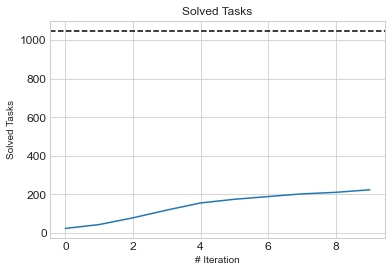

In [7]:
%matplotlib inline
plt.figure()
plt.plot(np.arange(len(results.learningCurve)),results.learningCurve, label="Solved")
plt.axhline(len(results.frontiersOverTime),linestyle="--",c="black", label="Total")
plt.title("Solved Tasks")
plt.xlabel("# Iteration")
plt.ylabel("Solved Tasks")
plt.show()

In [8]:
solved_tasks = []
primitive_counts = {}

for task, frontier in results.frontiersOverTime.items():
    f = frontier[-1]
    true_circuit = get_qiskit_circuit((dc.domains.quantum_circuits.tasks.n_qubit_tasks, task.target_circuit))
    print(f"---------------------------------------")
    print(f"Task {task.name}")
    print("True")
    print(true_circuit.circuit)
    
    if len(f.entries)>0:
        solved = f.entries[0]
        program = solved.program
        simplified_program = get_program_simplification(program)
        #reparse to update primitive functions
        simplified_program = dc.program.Program.parse(str(simplified_program))
        # arguments = task.examples[0][0] weird bug! ask Kevin
        arguments = (*range(dc.domains.quantum_circuits.tasks.n_qubit_tasks),(dc.domains.quantum_circuits.tasks.n_qubit_tasks,()))
        circuit = execute_program(simplified_program,arguments)
        print(f"reconstructed_circuit: {simplified_program}")
        reconstructed_circuit = get_qiskit_circuit(circuit)
        print(reconstructed_circuit.circuit)

        depth = len(execute_program(program,arguments)[1])
        solved_tasks.append([task,circuit, depth])
        
        for gate, *qubit in circuit[1]:
            if gate not in primitive_counts: primitive_counts[gate]=0
            primitive_counts[gate]+=1
    else:
        print("TASK UNSOLVED!")
print(f"Solved {len(solved_tasks)}/{len(results.taskSolutions)} tasks. ({len(solved_tasks)/len(results.taskSolutions)*100:2.2f}%)")

---------------------------------------
Task t_1984_(lambda (lambda (lambda (lambda (ch (cs $0 $1 $3) $2 $3)))))
True
               
q_0: ──■───────
       │       
q_1: ──┼────■──
     ┌─┴─┐┌─┴─┐
q_2: ┤ S ├┤ H ├
     └───┘└───┘
TASK UNSOLVED!
---------------------------------------
Task t_398_(lambda (lambda (lambda (lambda (h (cnot $0 $1 $2) $2)))))
True
               
q_0: ──■───────
     ┌─┴─┐┌───┐
q_1: ┤ X ├┤ H ├
     └───┘└───┘
q_2: ──────────
               
reconstructed_circuit: (lambda (lambda (lambda (lambda (h (cnot $0 $1 $2) $2)))))
               
q_0: ──■───────
     ┌─┴─┐┌───┐
q_1: ┤ X ├┤ H ├
     └───┘└───┘
q_2: ──────────
               
---------------------------------------
Task t_643_(lambda (lambda (lambda (lambda (tdg (ch $0 $3 $1) $1)))))
True
     ┌───┐┌─────┐
q_0: ┤ H ├┤ Tdg ├
     └─┬─┘└─────┘
q_1: ──┼─────────
       │         
q_2: ──■─────────
                 
TASK UNSOLVED!
---------------------------------------
Task t_1470_(lambda (lambda (lambda (l

In [9]:
def get_tasks_dict(results):
    tasks_dict = {}
    for task, frontiers in results.frontiersOverTime.items():
        for idx_f, f in enumerate(frontiers):
            if len(f.entries)>0:
                grammar = results.grammars[idx_f]
                if task.name not in tasks_dict: tasks_dict[task.name]=[]
                tasks_dict[task.name].append([idx_f, #iteration
                                            grammar.logLikelihood(f.entries[-1].program.infer(),f.entries[-1].program), #likelihood
                                            #   f.entries[-1]] # program frontier
                ])
    return tasks_dict

tasks_dict = get_tasks_dict(results)

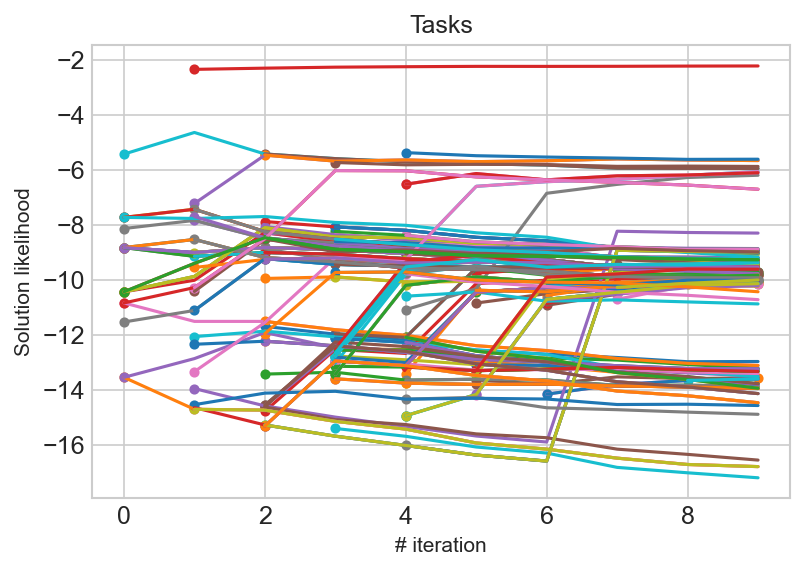

In [10]:
plt.figure(dpi=150)
for idx, (task, vals) in enumerate(tasks_dict.items()):
    vals_array = np.array(vals)
    plt.plot(*vals_array.T)
    plt.scatter(*vals_array[0], s=15)
    # plt.annotate(idx, vals_array[0])
plt.title("Tasks")
plt.xlabel("# iteration")
plt.ylabel("Solution likelihood")
plt.show()

Text(0, 0.5, 'Prob')

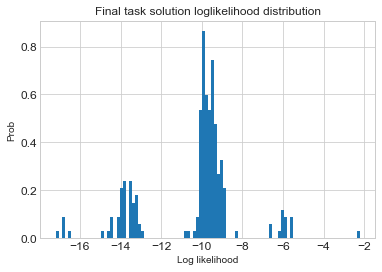

In [11]:
task_loglikelihoods =[t[-1][-1] for t in tasks_dict.values()]
plt.title("Final task solution loglikelihood distribution")
plt.hist(task_loglikelihoods,100, density=True);
plt.xlabel("Log likelihood")
plt.ylabel("Prob")

Comparison with full

In [12]:
test_tasks_dict = get_tasks_dict(results_test)
full_tasks_dict = get_tasks_dict(results_full)

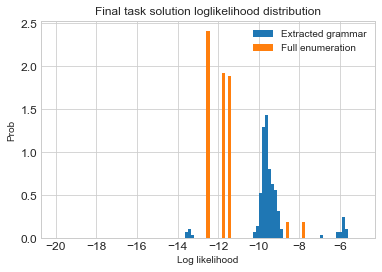

In [13]:
task_test_loglikelihoods =[t[-1][-1] for t in test_tasks_dict.values()]
task_full_loglikelihoods =[t[-1][-1] for t in full_tasks_dict.values()]
plt.title("Final task solution loglikelihood distribution")
plt.hist(task_test_loglikelihoods,np.linspace(-20,-5,100), density=True, label="Extracted grammar");
plt.hist(task_full_loglikelihoods,np.linspace(-20,-5,100), density=True, label="Full enumeration");
plt.legend()
plt.xlabel("Log likelihood")
plt.ylabel("Prob")
plt.show()

In [14]:
np.mean(task_test_loglikelihoods), np.std(task_test_loglikelihoods)

(-9.390905164793931, 1.250609614538754)

In [15]:
 np.mean(task_full_loglikelihoods),  np.std(task_full_loglikelihoods)

(-11.726555952913875, 0.9817621614600875)

In [16]:
grammar = results.grammars[-1]
print(print_simplified_grammar(grammar))

-0.443607	t0	$_
-1.7893763383773127	cnot                                                                       	tcircuit -> int -> int -> tcircuit
-2.2748841541590137	f0:(lambda (lambda (t (t $0 $1) $1)))                                      	int -> tcircuit -> tcircuit
-2.295403399020506	tdg                                                                        	tcircuit -> int -> tcircuit
-2.4769615503528923	h                                                                          	tcircuit -> int -> tcircuit
-2.4820679052897434	t                                                                          	tcircuit -> int -> tcircuit
-2.549629343092435	f5:(lambda (lambda (h (f1 $0 $1) $1)))                                     	int -> tcircuit -> tcircuit
-2.6203015080756242	f3:(lambda (lambda (f1 (f0 $0 $1) $0)))                                    	tcircuit -> int -> tcircuit
-2.680349262267178	f4:(lambda (lambda (f3 (f3 $0 $1) $1)))                                    	int -> tcircuit 

In [17]:
primitive_likelihood = {}

for idx_grammar, grammar in enumerate(results.grammars):
    for production in grammar.productions:
        p = production[-1]
        if isinstance(p,dc.program.Invented):
            p_string = str(get_program_simplification(dc.program.Program.parse(str(p)))[1:])
            p_name = f"f{p_string}"
        else: p_name = p
        
        if p_name not in primitive_likelihood:
            primitive_likelihood[p_name]=[]
        primitive_likelihood[p_name].append([idx_grammar,production[0]])


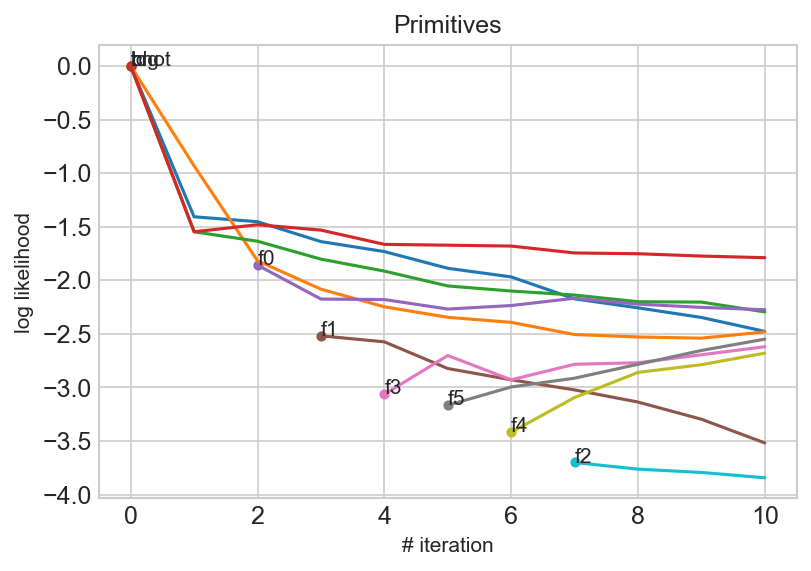

In [18]:
plt.figure(dpi=150)
plt.title("Primitives")
for primitive, likelihoods in primitive_likelihood.items():
    l_array = np.array(likelihoods)
    plt.plot(l_array[:,0], l_array[:,1], label=primitive)
    plt.scatter(*l_array[0], s=15)
    plt.annotate(primitive, l_array[0])
plt.xlabel("# iteration")
plt.ylabel("log likelihood")
plt.show()

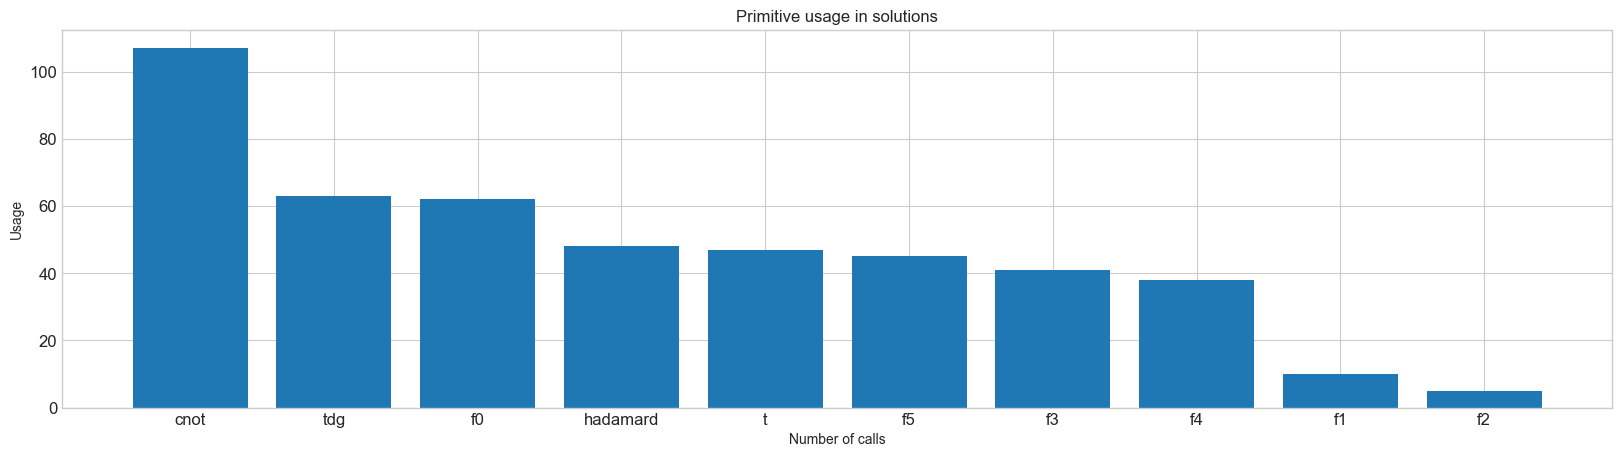

In [19]:
primitive_counts_list = list(primitive_counts.items())
primitive_counts_list.sort(key=lambda x: -x[1])
plt.figure(dpi=100, figsize=[20,5])
plt.title("Primitive usage in solutions")
plt.xlabel("Number of calls")
plt.ylabel("Usage")
plt.bar(np.array(primitive_counts_list)[:,0], np.array(primitive_counts_list)[:,1].astype(int))
plt.show()

In [62]:
# X    T ├┤ T ├┤ H ├┤ T ├┤ X ├┤ Tdg ├┤ H ├┤ Tdg ├┤ Tdg 
circuit = ([2,(("t",1),("t",1),("hadamard",1),("t",1),("cnot",0,1),("tdg",1),("hadamard",1),("tdg",1),("tdg",1))])
with QiskitTester(3,circuit=circuit) as QT:
    QT.circuit.ch(QT.q(0),QT.q(1))
QT.check()
QT.circuit.draw(), QT.transpile().draw()

u2 [0.7853981633974483, -1.5707963267948966]
cx []
u2 [-1.5707963267948966, 2.356194490192345]


(     ┌───┐
 q_0: ┤ H ├
      └─┬─┘
 q_1: ──■──
           ,
 global phase: π
      ┌───┐┌───┐┌───┐┌───┐┌───┐┌─────┐┌───┐┌─────┐┌─────┐
 q_0: ┤ T ├┤ T ├┤ H ├┤ T ├┤ X ├┤ Tdg ├┤ H ├┤ Tdg ├┤ Tdg ├
      └───┘└───┘└───┘└───┘└─┬─┘└─────┘└───┘└─────┘└─────┘
 q_1: ──────────────────────■────────────────────────────
                                                         )

In [63]:
mat = circuit_to_mat(circuit)
t= list(results.frontiersOverTime.keys())[21]

In [73]:
program = dc.program.Program.parse("(lambda (lambda (f1 $0 $1)))")

# Some fixed-size circuits

## 1-qubit gates

In [20]:
# X
with QiskitTester(1) as QT:
    QT.circuit.h(QT.q(0))
    QT.circuit.h(QT.q(0))
QT.circuit.draw(), QT.transpile().draw()

(   ┌───┐┌───┐
 q: ┤ H ├┤ H ├
    └───┘└───┘,
    
 q: 
    )

In [21]:
QT.result

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

X

In [23]:
# X
with QiskitTester(circuit=([3,(("x",2),)])) as QT:
    QT.circuit.x(QT.q(2))
QT.circuit.draw(), QT.transpile().draw()

x []


(     ┌───┐
 q_0: ┤ X ├
      └───┘
 q_1: ─────
           
 q_2: ─────
           ,
 global phase: π
      ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐
 q_0: ┤ H ├┤ T ├┤ T ├┤ T ├┤ T ├┤ H ├
      └───┘└───┘└───┘└───┘└───┘└───┘
 q_1: ──────────────────────────────
                                    
 q_2: ──────────────────────────────
                                    )

Y

In [22]:
# Y
with QiskitTester(circuit=([1,(("y",0),)])) as QT:
    QT.circuit.y(QT.q(0))
QT.circuit.draw(), QT.transpile().draw()

y []


(   ┌───┐
 q: ┤ Y ├
    └───┘,
 global phase: 3π/4
    ┌───┐┌───┐┌───┐┌───┐┌─────┐┌─────┐┌───┐┌───┐┌───┐
 q: ┤ H ├┤ T ├┤ T ├┤ H ├┤ Tdg ├┤ Tdg ├┤ H ├┤ T ├┤ T ├
    └───┘└───┘└───┘└───┘└─────┘└─────┘└───┘└───┘└───┘)

Z

In [25]:
with QiskitTester(circuit=([1,(("z",0),)])) as QT:
    QT.circuit.z(QT.q(0))
QT.circuit.draw(), QT.transpile().draw()

primitives.py:53 > Code consistent with Qiskit


z []


(   ┌───┐
 q: ┤ Z ├
    └───┘,
    ┌───┐┌───┐┌───┐┌───┐
 q: ┤ T ├┤ T ├┤ T ├┤ T ├
    └───┘└───┘└───┘└───┘)

T

In [28]:
# T = p(π/4)
with QiskitTester(circuit=([1,(("tdg",0),)])) as QT:
    QT.circuit.tdg(QT.q(0))
QT.circuit.draw(), QT.transpile().draw()

primitives.py:53 > Code consistent with Qiskit


tdg []


(   ┌─────┐
 q: ┤ Tdg ├
    └─────┘,
    ┌─────┐
 q: ┤ Tdg ├
    └─────┘)

S

In [29]:
# S = p(π/2)
with QiskitTester(circuit=([1,(("s",0),)])) as QT:
    QT.circuit.s(0)
QT.circuit.draw(), QT.transpile().draw()


primitives.py:53 > Code consistent with Qiskit


s []


(   ┌───┐
 q: ┤ S ├
    └───┘,
    ┌───┐┌───┐
 q: ┤ T ├┤ T ├
    └───┘└───┘)

$\sqrt X$

In [30]:
with QiskitTester(circuit=([1,(("sx",0),)])) as QT:
    QT.circuit.sx(QT.q(0))
QT.circuit.draw(), QT.transpile().draw()

primitives.py:53 > Code consistent with Qiskit


sx []


(   ┌────┐
 q: ┤ √X ├
    └────┘,
 global phase: π
    ┌───┐┌───┐┌───┐┌───┐
 q: ┤ H ├┤ T ├┤ T ├┤ H ├
    └───┘└───┘└───┘└───┘)

$\sqrt X ^\dag$

In [31]:
with QiskitTester(circuit=([1,(("sxdg",0),)])) as QT:
    QT.circuit.sxdg(QT.q(0))
QT.circuit.draw(), QT.transpile().draw()

primitives.py:53 > Code consistent with Qiskit


sxdg []


(   ┌──────┐
 q: ┤ √Xdg ├
    └──────┘,
 global phase: π
    ┌───┐┌─────┐┌─────┐┌───┐
 q: ┤ H ├┤ Tdg ├┤ Tdg ├┤ H ├
    └───┘└─────┘└─────┘└───┘)

Consistency checks

In [21]:
with QiskitTester(1) as QT:
    QT.circuit.append(qk.circuit.library.PhaseGate(np.pi),(0,))
transpiled=qk.transpile(QT.circuit, backend)
circuit2 = pm.run(transpiled)
discretized = skd(circuit2)
QT.circuit.draw(),transpiled.draw(), circuit2.draw(), discretized.draw()

p [3.141592653589793]


(   ┌──────┐
 q: ┤ P(π) ├
    └──────┘,
    ┌──────┐
 q: ┤ P(π) ├
    └──────┘,
    ┌──────┐
 q: ┤ P(π) ├
    └──────┘,
    ┌───┐┌───┐┌───┐┌───┐
 q: ┤ T ├┤ T ├┤ T ├┤ T ├
    └───┘└───┘└───┘└───┘)

In [32]:
with QiskitTester(1) as QT:
    QT.circuit.append(qk.circuit.library.PhaseGate(3*np.pi/4),(0,))
transpiled=qk.transpile(QT.circuit, backend)
circuit2 = pm.run(transpiled)
discretized = skd(circuit2)
QT.circuit.draw(),transpiled.draw(), circuit2.draw(), discretized.draw()

p [2.356194490192345]


(   ┌─────────┐
 q: ┤ P(3π/4) ├
    └─────────┘,
    ┌─────────┐
 q: ┤ P(3π/4) ├
    └─────────┘,
    ┌─────────┐
 q: ┤ P(3π/4) ├
    └─────────┘,
    ┌───┐┌───┐┌───┐
 q: ┤ T ├┤ T ├┤ T ├
    └───┘└───┘└───┘)

In [ ]:
with QiskitTester(1) as QT:
    QT.circuit.tdg(0)
    QT.circuit.tdg(0)
QT.circuit=pm.run(QT.circuit)
transpiled=qk.transpile(QT.circuit, backend, basis_gates)
discretized = skd(transpiled)
QT.circuit.draw(),transpiled.draw(),discretized.draw()

In [ ]:
with QiskitTester(1) as QT:
    QT.circuit.append(qk.circuit.library.PhaseGate(3*np.pi/2),(0,))
transpiled=qk.transpile(QT.circuit, backend)
circuit2 = pm.run(transpiled)
discretized = skd(circuit2)
QT.circuit.draw(),transpiled.draw(), circuit2.draw(), discretized.draw()

In [ ]:
with QiskitTester(1) as QT:
    QT.circuit.append(qk.circuit.library.PhaseGate(5*np.pi/2),(0,))
transpiled=qk.transpile(QT.circuit, backend)
circuit2 = pm.run(transpiled)
discretized = skd(circuit2)
QT.circuit.draw(),transpiled.draw(), circuit2.draw(), discretized.draw()

In [ ]:
# (just as a test)
# we should be able to transpile this one
with QiskitTester(1) as QT:
    QT.circuit.p(np.pi/8,0)
    QT.circuit.p(np.pi/8,0)
transpiled=qk.transpile(QT.circuit, backend)
circuit2 = pm.run(transpiled)
discretized = skd(circuit2)
QT.circuit.draw(),transpiled.draw(),discretized.draw()

In [37]:
# we should be able to transpile this one
with QiskitTester(1) as QT:
    QT.circuit.p(np.pi/8,0)
    QT.circuit.p(np.pi/8,0)
transpiled=qk.transpile(QT.circuit, backend)
circuit2 = pm.run(transpiled)
discretized = skd(circuit2)
QT.circuit.draw(),transpiled.draw(),discretized.draw()

u1 [0.7853981633974483]


(   ┌────────┐┌────────┐
 q: ┤ P(π/8) ├┤ P(π/8) ├
    └────────┘└────────┘,
    ┌─────────┐
 q: ┤ U1(π/4) ├
    └─────────┘,
    ┌───┐
 q: ┤ T ├
    └───┘)

## 2-qubit gates

Controlled-Y

In [33]:
with QiskitTester(circuit=([2,(("cy",0,1),)])) as QT:
    QT.circuit.cy(QT.q(0),QT.q(1))
QT.circuit.draw(), QT.transpile().draw()

primitives.py:53 > Code consistent with Qiskit


cy []


(     ┌───┐
 q_0: ┤ Y ├
      └─┬─┘
 q_1: ──■──
           ,
      ┌─────┐┌─────┐┌───┐┌───┐┌───┐
 q_0: ┤ Tdg ├┤ Tdg ├┤ X ├┤ T ├┤ T ├
      └─────┘└─────┘└─┬─┘└───┘└───┘
 q_1: ────────────────■────────────
                                   )

CZ

In [34]:
with QiskitTester(circuit=([2,(("cz",0,1),)])) as QT:
    QT.circuit.cz(QT.q(0),QT.q(1))
QT.circuit.draw(), QT.transpile().draw()

primitives.py:53 > Code consistent with Qiskit


cz []


(        
 q_0: ─■─
       │ 
 q_1: ─■─
         ,
      ┌───┐┌───┐┌───┐
 q_0: ┤ H ├┤ X ├┤ H ├
      └───┘└─┬─┘└───┘
 q_1: ───────■───────
                     )

SWAP

In [35]:
with QiskitTester(circuit=([2,(("swap",0,1),)])) as QT:
    QT.circuit.swap(QT.q(0),QT.q(1))
QT.circuit.draw(), QT.transpile().draw()

primitives.py:53 > Code consistent with Qiskit


swap []


(        
 q_0: ─X─
       │ 
 q_1: ─X─
         ,
      ┌───┐     ┌───┐
 q_0: ┤ X ├──■──┤ X ├
      └─┬─┘┌─┴─┐└─┬─┘
 q_1: ──■──┤ X ├──■──
           └───┘     )

iSWAP

In [36]:
with QiskitTester(circuit=([2,(("iswap",0,1),)])) as QT:
    QT.circuit.iswap(QT.q(0),QT.q(1))
QT.circuit.draw(), QT.transpile().draw()

primitives.py:53 > Code consistent with Qiskit


s []
u2 [0.0, -1.5707963267948966]
cx []
cx []
h []


(     ┌────────┐
 q_0: ┤1       ├
      │  Iswap │
 q_1: ┤0       ├
      └────────┘,
 global phase: π
      ┌───┐┌───┐     ┌───┐     ┌───┐
 q_0: ┤ T ├┤ T ├─────┤ X ├──■──┤ H ├
      ├───┤├───┤┌───┐└─┬─┘┌─┴─┐└───┘
 q_1: ┤ T ├┤ T ├┤ H ├──■──┤ X ├─────
      └───┘└───┘└───┘     └───┘     )

Controlled S

In [37]:
with QiskitTester(circuit=([2,(("cs",0,1),)])) as QT:
    QT.circuit.append(qk.circuit.library.SGate().control(1), (0,1))
QT.circuit.draw(), QT.transpile().draw()

primitives.py:53 > Code consistent with Qiskit


cp [1.5707963267948966]


(          
 q_0: ──■──
      ┌─┴─┐
 q_1: ┤ S ├
      └───┘,
      ┌───┐                      
 q_0: ┤ T ├──■───────────■───────
      └───┘┌─┴─┐┌─────┐┌─┴─┐┌───┐
 q_1: ─────┤ X ├┤ Tdg ├┤ X ├┤ T ├
           └───┘└─────┘└───┘└───┘)

In [13]:
np.round(QT.result)

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+1.j]])

DCX
(Double CNOT)

In [23]:
with QiskitTester(2) as QT:
    QT.circuit.dcx(QT.q(0),QT.q(1))
QT.circuit.draw(), QT.transpile().draw()

cx []
cx []


(     ┌──────┐
 q_0: ┤1     ├
      │  Dcx │
 q_1: ┤0     ├
      └──────┘,
      ┌───┐     
 q_0: ┤ X ├──■──
      └─┬─┘┌─┴─┐
 q_1: ──■──┤ X ├
           └───┘)

CH
(Controlled Hadamard)

In [44]:
with QiskitTester(circuit=([2,(("ch",0,1),)])) as QT:
    QT.circuit.ch(QT.q(0),QT.q(1))
QT.circuit.draw(), QT.transpile().draw()

primitives.py:53 > Code consistent with Qiskit


u2 [0.7853981633974483, -1.5707963267948966]
cx []
u2 [-1.5707963267948966, 2.356194490192345]


(     ┌───┐
 q_0: ┤ H ├
      └─┬─┘
 q_1: ──■──
           ,
 global phase: π
      ┌───┐┌───┐┌───┐┌───┐┌───┐┌─────┐┌───┐┌─────┐┌─────┐
 q_0: ┤ T ├┤ T ├┤ H ├┤ T ├┤ X ├┤ Tdg ├┤ H ├┤ Tdg ├┤ Tdg ├
      └───┘└───┘└───┘└───┘└─┬─┘└─────┘└───┘└─────┘└─────┘
 q_1: ──────────────────────■────────────────────────────
                                                         )

### Consistency checks

In [16]:
# Controlled Phase(α) requires to be able to do Phase(α/2)
with QiskitTester(2) as QT:
    QT.circuit.append(qk.circuit.library.CPhaseGate(np.pi/4),(0,1))
transpiled=qk.transpile(QT.circuit, backend)
circuit2 = pm.run(transpiled)
discretized = skd(circuit2)
QT.circuit.draw(),transpiled.draw(), circuit2.draw(), discretized.draw()

cp [0.7853981633974483]


(              
 q_0: ─■───────
       │P(π/4) 
 q_1: ─■───────
               ,
               
 q_0: ─■───────
       │P(π/4) 
 q_1: ─■───────
               ,
      ┌────────┐                               
 q_0: ┤ P(π/8) ├──■───────────────■────────────
      └────────┘┌─┴─┐┌─────────┐┌─┴─┐┌────────┐
 q_1: ──────────┤ X ├┤ P(-π/8) ├┤ X ├┤ P(π/8) ├
                └───┘└─────────┘└───┘└────────┘,
 global phase: 3.7306
      ┌───┐┌─────┐┌───┐┌─────┐┌───┐┌─────┐┌───┐┌─────┐┌───┐┌─────┐┌─────┐┌───┐»
 q_0: ┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ Tdg ├┤ H ├»
      └───┘└─────┘└───┘└─────┘└───┘└─────┘└───┘└─────┘└───┘└─────┘└─────┘└───┘»
 q_1: ────────────────────────────────────────────────────────────────────────»
                                                                              »
 «     ┌───┐┌───┐┌───┐┌───┐┌─────┐┌───┐┌─────┐┌───┐┌─────┐┌───┐┌─────┐┌───┐»
 «q_0: ┤ T ├┤ H ├┤ T ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├»
 «     └───┘└───┘└───

In [ ]:
# This is CS, but can we transpile it?
with QiskitTester(2) as QT:
    QT.circuit.cp(np.pi/2,QT.q(0),QT.q(1))
transpiled=qk.transpile(QT.circuit, backend)
circuit2 = pm.run(transpiled)
discretized = skd(circuit2)
QT.circuit.draw(),transpiled.draw(),discretized.draw()

## 3-qubit gates

Controlled-Controlled X

In [25]:
with QiskitTester(3) as QT:
    QT.circuit.ccx(QT.q(0),QT.q(1),QT.q(2))
QT.circuit.draw(), QT.transpile().draw()

ccx []


(     ┌───┐
 q_0: ┤ X ├
      └─┬─┘
 q_1: ──■──
        │  
 q_2: ──■──
           ,
      ┌───┐┌───┐┌─────┐┌───┐┌───┐┌───┐┌─────┐┌───┐┌───┐ ┌───┐      
 q_0: ┤ H ├┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ T ├─┤ H ├──────
      └───┘└─┬─┘└─────┘└─┬─┘└───┘└─┬─┘└┬───┬┘└─┬─┘├───┤┌┴───┴┐┌───┐
 q_1: ───────■───────────┼─────────■───┤ T ├───┼──┤ X ├┤ Tdg ├┤ X ├
                         │             └───┘   │  └─┬─┘└┬───┬┘└─┬─┘
 q_2: ───────────────────■─────────────────────■────■───┤ T ├───■──
                                                        └───┘      )

Controlled-Swap

In [26]:
with QiskitTester(3) as QT:
    QT.circuit.cswap(QT.q(0),QT.q(1),QT.q(2))
QT.circuit.draw(), QT.transpile().draw()

cswap []


(        
 q_0: ─X─
       │ 
 q_1: ─X─
       │ 
 q_2: ─■─
         ,
           ┌───┐┌───┐┌─────┐┌───┐┌───┐┌───┐┌─────┐┌───┐┌───┐ ┌───┐           
 q_0: ──■──┤ H ├┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ T ├─┤ H ├────────■──
      ┌─┴─┐└───┘└─┬─┘└─────┘└─┬─┘└───┘└─┬─┘└┬───┬┘└─┬─┘├───┤┌┴───┴┐┌───┐┌─┴─┐
 q_1: ┤ X ├───────■───────────┼─────────■───┤ T ├───┼──┤ X ├┤ Tdg ├┤ X ├┤ X ├
      └───┘                   │             └───┘   │  └─┬─┘└┬───┬┘└─┬─┘└───┘
 q_2: ────────────────────────■─────────────────────■────■───┤ T ├───■───────
                                                             └───┘           )

## Variable size / parametric

Permutation

In [27]:
with QiskitTester(3) as QT:
    QT.circuit.append(qk.circuit.library.Permutation(3,[2,0,1]), 
                      (QT.q(0),QT.q(1),QT.q(2)))
QT.circuit.draw(), QT.transpile().draw()

swap []
swap []


(     ┌──────────────────────┐
 q_0: ┤2                     ├
      │                      │
 q_1: ┤1 permutation_[2,0,1] ├
      │                      │
 q_2: ┤0                     ├
      └──────────────────────┘,
      ┌───┐     ┌───┐               
 q_0: ┤ X ├──■──┤ X ├───────────────
      └─┬─┘┌─┴─┐└─┬─┘┌───┐     ┌───┐
 q_1: ──■──┤ X ├──■──┤ X ├──■──┤ X ├
           └───┘     └─┬─┘┌─┴─┐└─┬─┘
 q_2: ─────────────────■──┤ X ├──■──
                          └───┘     )

InnerProduct
(but only specific sizes)

In [ ]:
with QiskitTester(4) as QT:
    QT.circuit.append(qk.circuit.library.InnerProduct(2), 
                      (QT.q(0),QT.q(1),QT.q(2),QT.q(3)))
QT.circuit.draw(), QT.transpile().draw()

cz []
cz []


(     ┌────────────────┐
 q_0: ┤3               ├
      │                │
 q_1: ┤2               ├
      │  inner_product │
 q_2: ┤1               ├
      │                │
 q_3: ┤0               ├
      └────────────────┘,
      ┌───┐┌───┐┌───┐     
 q_0: ┤ H ├┤ X ├┤ H ├─────
      ├───┤└─┬─┘├───┤┌───┐
 q_1: ┤ H ├──┼──┤ X ├┤ H ├
      └───┘  │  └─┬─┘└───┘
 q_2: ───────■────┼───────
                  │       
 q_3: ────────────■───────
                          )

AND

In [28]:
with QiskitTester(3) as QT:
    QT.circuit.append(qk.circuit.library.AND(2), 
                      (QT.q(0),QT.q(1),QT.q(2)))
QT.circuit.draw(), QT.transpile().draw()

ccx []


(     ┌──────┐
 q_0: ┤2     ├
      │      │
 q_1: ┤1 and ├
      │      │
 q_2: ┤0     ├
      └──────┘,
      ┌───┐┌───┐┌─────┐┌───┐┌───┐┌───┐┌─────┐┌───┐┌───┐ ┌───┐      
 q_0: ┤ H ├┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ T ├─┤ H ├──────
      └───┘└─┬─┘└─────┘└─┬─┘└───┘└─┬─┘└┬───┬┘└─┬─┘├───┤┌┴───┴┐┌───┐
 q_1: ───────■───────────┼─────────■───┤ T ├───┼──┤ X ├┤ Tdg ├┤ X ├
                         │             └───┘   │  └─┬─┘└┬───┬┘└─┬─┘
 q_2: ───────────────────■─────────────────────■────■───┤ T ├───■──
                                                        └───┘      )

OR

In [29]:
with QiskitTester(3) as QT:
    QT.circuit.append(qk.circuit.library.OR(2), 
                      (QT.q(0),QT.q(1),QT.q(2)))
QT.circuit.draw(), QT.transpile().draw()

x []
x []
x []
ccx []
x []
x []


(     ┌─────┐
 q_0: ┤2    ├
      │     │
 q_1: ┤1 or ├
      │     │
 q_2: ┤0    ├
      └─────┘,
 global phase: π
      ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌─────┐┌───┐┌───┐┌───┐┌─────┐┌───┐»
 q_0: ┤ H ├┤ T ├┤ T ├┤ T ├┤ T ├┤ H ├┤ H ├┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├»
      ├───┤├───┤├───┤├───┤├───┤├───┤└───┘└─┬─┘└─────┘└─┬─┘└───┘└─┬─┘└┬───┬┘└─┬─┘»
 q_1: ┤ H ├┤ T ├┤ T ├┤ T ├┤ T ├┤ H ├───────■───────────┼─────────■───┤ T ├───┼──»
      ├───┤├───┤├───┤├───┤├───┤├───┤                   │             └───┘   │  »
 q_2: ┤ H ├┤ T ├┤ T ├┤ T ├┤ T ├┤ H ├───────────────────■─────────────────────■──»
      └───┘└───┘└───┘└───┘└───┘└───┘                                            »
 «     ┌───┐ ┌───┐                                    
 «q_0: ┤ T ├─┤ H ├────────────────────────────────────
 «     ├───┤┌┴───┴┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐
 «q_1: ┤ X ├┤ Tdg ├┤ X ├┤ H ├┤ T ├┤ T ├┤ T ├┤ T ├┤ H ├
 «     └─┬─┘└┬───┬┘└─┬─┘├───┤├───┤├───┤├───┤├───┤├───┤
 «q_2: ──■───┤ T ├───■──┤ H ├┤ T ├┤

CarryAdder (CDKM)

In [40]:
with QiskitTester(6) as QT:
    QT.circuit.append(qk.circuit.library.CDKMRippleCarryAdder(2), 
                      (QT.q(0),QT.q(1),QT.q(2),QT.q(3),QT.q(4),QT.q(5)))
QT.circuit.draw(), QT.transpile().draw()

cx []
cx []
cx []
ccx []
cx []
ccx []
cx []
ccx []
cx []
cx []
ccx []
cx []
cx []


(     ┌───────────────────────┐
 q_0: ┤5                      ├
      │                       │
 q_1: ┤4                      ├
      │                       │
 q_2: ┤3                      ├
      │  CDKMRippleCarryAdder │
 q_3: ┤2                      ├
      │                       │
 q_4: ┤1                      ├
      │                       │
 q_5: ┤0                      ├
      └───────────────────────┘,
                                                                           »
 q_0: ─────────────────────────────────────────────────────────────────────»
      ┌───┐                                                                »
 q_1: ┤ X ├────────────────────────────────────────────────────────────────»
      └─┬─┘┌───┐                                      ┌───┐           ┌───┐»
 q_2: ──┼──┤ X ├────────────■─────────────────────■───┤ T ├───────────┤ X ├»
        │  └─┬─┘            │                     │   └───┘           └─┬─┘»
 q_3: ──■────┼──────────────┼───────────────

CarryAdder (VBER)

In [41]:
with QiskitTester(7) as QT:
    QT.circuit.append(qk.circuit.library.VBERippleCarryAdder(2), 
                      (QT.q(0),QT.q(1),QT.q(2),QT.q(3),QT.q(4),QT.q(5),QT.q(6)))
QT.circuit.draw(), QT.transpile().draw()

ccx []
cx []
ccx []
cx []
ccx []
ccx []
cx []
ccx []
cx []
ccx []
cx []
cx []


(     ┌──────────────────────┐
 q_0: ┤6                     ├
      │                      │
 q_1: ┤5                     ├
      │                      │
 q_2: ┤4                     ├
      │                      │
 q_3: ┤3 VBERippleCarryAdder ├
      │                      │
 q_4: ┤2                     ├
      │                      │
 q_5: ┤1                     ├
      │                      │
 q_6: ┤0                     ├
      └──────────────────────┘,
      ┌───┐     ┌───┐┌─────┐     ┌───┐┌───┐     ┌───┐┌─────┐     ┌───┐┌───┐»
 q_0: ┤ H ├─────┤ X ├┤ Tdg ├─────┤ X ├┤ T ├─────┤ X ├┤ Tdg ├─────┤ X ├┤ T ├»
      ├───┤┌───┐└─┬─┘├─────┤┌───┐└─┬─┘├───┤┌───┐└─┬─┘├─────┤┌───┐└─┬─┘├───┤»
 q_1: ┤ H ├┤ X ├──┼──┤ Tdg ├┤ X ├──┼──┤ T ├┤ X ├──┼──┤ Tdg ├┤ X ├──┼──┤ T ├»
      └───┘└─┬─┘  │  └─────┘└─┬─┘  │  └───┘└─┬─┘  │  └┬───┬┘└─┬─┘  │  ├───┤»
 q_2: ───────■────┼───────────┼────┼─────────■────┼───┤ T ├───┼────┼──┤ X ├»
                  │           │    │              │   ├───┤   │    │  └─

Weighted Adder
(long)

In [42]:
with QiskitTester(5) as QT:
    QT.circuit.append(qk.circuit.library.WeightedAdder(2), 
                      (QT.q(0),QT.q(1),QT.q(2),QT.q(3),QT.q(4)))
QT.circuit.draw(), QT.transpile().draw()

ccx []
cx []
x []
ccx []
ccx []
x []
ccx []
cx []
x []
ccx []
ccx []
x []


(     ┌────────┐
 q_0: ┤4       ├
      │        │
 q_1: ┤3       ├
      │        │
 q_2: ┤2 adder ├
      │        │
 q_3: ┤1       ├
      │        │
 q_4: ┤0       ├
      └────────┘,
      ┌───┐┌───┐┌─────┐┌───┐┌───┐┌───┐┌─────┐┌───┐┌───┐ ┌───┐                  »
 q_0: ┤ H ├┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ T ├─┤ H ├───■──────────────»
      ├───┤└─┬─┘└─────┘└─┬─┘└───┘└─┬─┘└─────┘└─┬─┘└───┘ └───┘ ┌─┴─┐┌─────┐     »
 q_1: ┤ H ├──┼───────────┼─────────┼───────────┼──────────────┤ X ├┤ Tdg ├─────»
      └───┘  │           │         │   ┌───┐   │  ┌───┐┌─────┐├───┤└┬───┬┘┌───┐»
 q_2: ───────■───────────┼─────────■───┤ T ├───┼──┤ X ├┤ Tdg ├┤ H ├─┤ T ├─┤ T ├»
                         │             └───┘   │  └─┬─┘└─────┘└───┘ └───┘ └───┘»
 q_3: ───────────────────┼─────────────────────┼────┼──────────────────────────»
                         │                     │    │   ┌───┐                  »
 q_4: ───────────────────■─────────────────────■────■───┤ T ├──────────────────»
  

In [45]:
with QiskitTester(4) as QT:
    QT.circuit.append(qk.circuit.library.IntegerComparator(2, value=3), 
                      (QT.q(0),QT.q(1),QT.q(2),QT.q(3),))
QT.circuit.draw(), QT.transpile().draw()

cx []
ccx []
cx []


(     ┌──────┐
 q_0: ┤3     ├
      │      │
 q_1: ┤2     ├
      │  cmp │
 q_2: ┤1     ├
      │      │
 q_3: ┤0     ├
      └──────┘,
           ┌───┐                            ┌───┐           ┌───┐┌─────┐┌───┐»
 q_0: ─────┤ X ├──■─────────────────────■───┤ T ├───────────┤ X ├┤ Tdg ├┤ X ├»
      ┌───┐└─┬─┘┌─┴─┐┌─────┐┌───┐┌───┐┌─┴─┐┌┴───┴┐┌───┐┌───┐└─┬─┘└┬───┬┘└─┬─┘»
 q_1: ┤ H ├──┼──┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ T ├──┼───┤ H ├───┼──»
      └───┘  │  └───┘└─────┘└─┬─┘└───┘└───┘└─────┘└─┬─┘└───┘  │   ├───┤   │  »
 q_2: ───────┼────────────────■─────────────────────■─────────■───┤ T ├───■──»
             │                                                    └───┘      »
 q_3: ───────■───────────────────────────────────────────────────────────────»
                                                                             »
 «     ┌───┐
 «q_0: ┤ X ├
 «     └─┬─┘
 «q_1: ──┼──
 «       │  
 «q_2: ──┼──
 «       │  
 «q_3: ──■──
 «          )

Reciprocal

In [47]:
with QiskitTester(3) as QT:
    QT.circuit.append(qk.circuit.library.ExactReciprocal(2, scaling=1.5), 
                      (QT.q(0),QT.q(1),QT.q(2)))
QT.circuit.draw(), QT.transpile().draw()

cx []
cx []
cx []
cx []


(     ┌──────┐
 q_0: ┤2     ├
      │      │
 q_1: ┤1 1/x ├
      │      │
 q_2: ┤0     ├
      └──────┘,
      ┌───┐┌───┐┌───┐┌───┐
 q_0: ┤ X ├┤ X ├┤ X ├┤ X ├
      └─┬─┘└─┬─┘└─┬─┘└─┬─┘
 q_1: ──┼────■────┼────■──
        │         │       
 q_2: ──■─────────■───────
                          )

'Hidden Linear Function'

In [61]:
with QiskitTester(3) as QT:
    QT.circuit.append(qk.circuit.library.HiddenLinearFunction([[1, 1, 0], 
                                                               [1, 0, 1], 
                                                               [0, 1, 1]]), 
                      (QT.q(0),QT.q(1),QT.q(2)))
QT.circuit.draw(), QT.transpile().draw()

h []
h []
h []
cz []
cz []
u2 [0.0, -1.5707963267948966]
h []
u2 [0.0, -1.5707963267948966]


(     ┌───────────────────────────────────┐
 q_0: ┤2                                  ├
      │                                   │
 q_1: ┤1 hlf: [[1 1 0]
  [1 0 1]
  [0 1 1]] ├
      │                                   │
 q_2: ┤0                                  ├
      └───────────────────────────────────┘,
      ┌───┐┌───┐          ┌───┐┌───┐┌───┐┌───┐┌───┐
 q_0: ┤ H ├┤ H ├──────────┤ X ├┤ H ├┤ T ├┤ T ├┤ H ├
      ├───┤├───┤┌───┐┌───┐└─┬─┘├───┤└───┘└───┘└───┘
 q_1: ┤ H ├┤ H ├┤ X ├┤ H ├──■──┤ H ├───────────────
      ├───┤└───┘└─┬─┘├───┤┌───┐├───┤               
 q_2: ┤ H ├───────■──┤ T ├┤ T ├┤ H ├───────────────
      └───┘          └───┘└───┘└───┘               )

Grover operator
(depends on the oracle)

In [71]:
# Grover Operator 
with QiskitTester(2) as QT:
    oracle = QuantumCircuit(2)
    oracle.z(0)
    
    QT.circuit.append(qk.circuit.library.GroverOperator(oracle), 
                      (QT.q(0),QT.q(1)))
QT.circuit.draw(), QT.transpile().draw()

u1 [-3.141592653589793]
u2 [0.0, -3.141592653589793]
cx []
u1 [-3.141592653589793]
u2 [-3.141592653589793, -3.141592653589793]


(     ┌────┐
 q_0: ┤1   ├
      │  Q │
 q_1: ┤0   ├
      └────┘,
 global phase: π
      ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐     
 q_0: ┤ T ├┤ T ├┤ T ├┤ T ├┤ X ├┤ T ├┤ T ├┤ T ├┤ T ├─────
      ├───┤└───┘└───┘└───┘└─┬─┘├───┤├───┤├───┤├───┤┌───┐
 q_1: ┤ H ├─────────────────■──┤ H ├┤ T ├┤ T ├┤ T ├┤ T ├
      └───┘                    └───┘└───┘└───┘└───┘└───┘)

## Quantum State Preparation

In [ ]:
# In general: 
# GHZ and W state preparation algorithms https://arxiv.org/pdf/1807.05572.pdf
# W states: https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/awards/teach_me_qiskit_2018/w_state/W%20State%201%20-%20Multi-Qubit%20Systems.ipynb
# Cluster states https://www.cs.umd.edu/class/spring2018/cmsc457/report/Cluster_State_Quantum_Computing.pdf

Bell
(2-qubit)

In [50]:
# Bell 
with QiskitTester(2) as QT:
    QT.circuit.h(QT.q(0))
    QT.circuit.cx(QT.q(0),QT.q(1))
QT.circuit.draw(),transpiled.draw(),discretized.draw()

(          ┌───┐
 q_0: ─────┤ X ├
      ┌───┐└─┬─┘
 q_1: ┤ H ├──■──
      └───┘     ,
                          
 q_0: ────────────────────
                          
 q_1: ────────────────────
      ┌───┐┌───┐┌───┐┌───┐
 q_2: ┤ X ├┤ X ├┤ X ├┤ X ├
      └─┬─┘└─┬─┘└─┬─┘└─┬─┘
 q_3: ──┼────■────┼────■──
        │         │       
 q_4: ──■─────────■───────
                          ,
                          
 q_0: ────────────────────
                          
 q_1: ────────────────────
      ┌───┐┌───┐┌───┐┌───┐
 q_2: ┤ X ├┤ X ├┤ X ├┤ X ├
      └─┬─┘└─┬─┘└─┬─┘└─┬─┘
 q_3: ──┼────■────┼────■──
        │         │       
 q_4: ──■─────────■───────
                          )

GHZ
(3-qubit, but can be generalized)

In [52]:
# GHZ
with QiskitTester(3) as QT:
    QT.circuit.h(QT.q(0))
    QT.circuit.cx(QT.q(0),QT.q(1))
    QT.circuit.cx(QT.q(0),QT.q(2))
QT.circuit.draw(), QT.transpile().draw()

h []
cx []
cx []


(               ┌───┐
 q_0: ──────────┤ X ├
           ┌───┐└─┬─┘
 q_1: ─────┤ X ├──┼──
      ┌───┐└─┬─┘  │  
 q_2: ┤ H ├──■────■──
      └───┘          ,
                ┌───┐
 q_0: ──────────┤ X ├
           ┌───┐└─┬─┘
 q_1: ─────┤ X ├──┼──
      ┌───┐└─┬─┘  │  
 q_2: ┤ H ├──■────■──
      └───┘          )

In [ ]:
# W this is too long
with QiskitTester(3) as QT:
    QT.circuit.ry(2*np.arccos(1/np.sqrt(3)),QT.q(0))
    QT.circuit.h(QT.q(1))
    QT.circuit.cnot(QT.q(1),QT.q(2))
    QT.circuit.cnot(QT.q(0),QT.q(1))
    QT.circuit.x(QT.q(0))
QT.circuit.draw(), QT.transpile().draw()

In [59]:
# Graph state
with QiskitTester(5) as QT:
    QT.circuit.append(qk.circuit.library.GraphState([[0., 1., 0., 0., 1.,],
                                                     [1., 0., 1., 0., 0.,],
                                                     [0., 1., 0., 1., 0.],
                                                     [0., 0., 1., 0., 1.],
                                                     [1., 0., 0., 1., 0.]]), 
                      (QT.q(0),QT.q(1),QT.q(2),QT.q(3),QT.q(4)))
QT.circuit.draw(), QT.transpile().draw()

h []
h []
h []
h []
h []
cz []
cz []
cz []
cz []
cz []


(     »
 q_0: »
      »
 q_1: »
      »
 q_2: »
      »
 q_3: »
      »
 q_4: »
      »
 «     ┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
 «q_0: ┤4                                                                                                   ├
 «     │                                                                                                    │
 «q_1: ┤3                                                                                                   ├
 «     │                                                                                                    │
 «q_2: ┤2 graph: [[0. 1. 0. 0. 1.]
  [1. 0. 1. 0. 0.]
  [0. 1. 0. 1. 0.]
  [0. 0. 1. 0. 1.]
  [1. 0. 0. 1. 0.]] ├
 «     │                                                                                                    │
 «q_3: ┤1                                                                                                   ├
 «     │                    

# Too Long

In [2]:
## WE NEED CP(pi/8) FOR QFT!
# It works but it is huge!
with QiskitTester(3) as QT:
    QT.circuit.append(qk.circuit.library.QFT(3), 
                      (QT.q(0),QT.q(1),QT.q(2)))
transpiled=qk.transpile(QT.circuit, backend)
circuit2 = pm.run(transpiled)
discretized = skd(circuit2)
QT.circuit.draw(),transpiled.draw(),discretized.draw()

h []
cp [1.5707963267948966]
h []
cp [0.7853981633974483]
cp [1.5707963267948966]
h []
swap []


(     ┌──────┐
 q_0: ┤2     ├
      │      │
 q_1: ┤1 QFT ├
      │      │
 q_2: ┤0     ├
      └──────┘,
      ┌───┐                                        
 q_0: ┤ H ├─■─────────────■──────────────────────X─
      └───┘ │P(π/2) ┌───┐ │                      │ 
 q_1: ──────■───────┤ H ├─┼────────■─────────────┼─
                    └───┘ │P(π/4)  │P(π/2) ┌───┐ │ 
 q_2: ────────────────────■────────■───────┤ H ├─X─
                                           └───┘   ,
 global phase: 3.7306
      ┌───┐┌───┐                 ┌───┐┌─────┐┌───┐┌─────┐┌───┐┌─────┐┌───┐»
 q_0: ┤ H ├┤ T ├──■───────────■──┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├»
      └───┘└───┘┌─┴─┐┌─────┐┌─┴─┐├───┤└┬───┬┘├───┤└─────┘└───┘└─────┘└───┘»
 q_1: ──────────┤ X ├┤ Tdg ├┤ X ├┤ T ├─┤ H ├─┤ T ├────────────────────────»
                └───┘└─────┘└───┘└───┘ └───┘ └───┘                        »
 q_2: ────────────────────────────────────────────────────────────────────»
                                                   

In [ ]:
## WE NEED CP(pi/8) FOR QFT!
# It works but it is huge!
with QiskitTester(4) as QT:
    QT.circuit.append(qk.circuit.library.QFT(4), 
                      (QT.q(0),QT.q(1),QT.q(2),QT.q(3)))
QT.circuit.draw(), QT.transpile().draw()

In [ ]:
# very long!
with QiskitTester(5) as QT:
    QT.circuit.append(qk.circuit.library.QuadraticForm(2, linear=[1,-2], 
                                                       quadratic=[[1,2],[2,0.5]]), 
                      (QT.q(0),QT.q(1),QT.q(2),QT.q(3),))
QT.circuit.draw(), QT.transpile().draw()

In [ ]:
# Too long
with QiskitTester(4) as QT:
    QT.circuit.append(qk.circuit.library.IQP([[6, 5, 3], [5, 4, 5], [3, 5, 1]]), 
                      (QT.q(0),QT.q(1),QT.q(2)))
QT.circuit.draw(), QT.transpile().draw()

In [ ]:
# Huge
# U(π/2,0,π,0)  not found
with QiskitTester(9) as QT:
    QT.circuit.append(qk.circuit.library.HRSCumulativeMultiplier(2), 
                      (QT.q(0),QT.q(1),QT.q(2),QT.q(3),QT.q(4),QT.q(5),QT.q(6),QT.q(7),QT.q(8)))
transpiled=qk.transpile(QT.circuit, backend)
circuit2 = pm.run(transpiled)
discretized = skd(circuit2)
QT.circuit.draw(),transpiled.draw(),discretized.draw()

In [ ]:
#!Huge
with QiskitTester(8) as QT:
    QT.circuit.append(qk.circuit.library.RGQFTMultiplier(2), 
                      (QT.q(0),QT.q(1),QT.q(2),QT.q(3),QT.q(4),QT.q(5),QT.q(6),QT.q(7)))
transpiled=qk.transpile(QT.circuit, backend)
circuit2 = pm.run(transpiled)
discretized = skd(circuit2)
QT.circuit.draw(),transpiled.draw(),discretized.draw()

In [ ]:
#incredibly huge
from qiskit import algorithms
circuit = qk.algorithms.Shor().construct_circuit(7)
transpiled=qk.transpile(circuit, backend)
circuit2 = pm.run(transpiled)
discretized = skd(circuit2)
circuit.draw(),transpiled.draw(),discretized.draw()

In [ ]:
# Other algorithms - but should be evaluated with reasonable arguments!
# https://qiskit.org/documentation/apidoc/algorithms.html

In [ ]:
# Quantum Volume (seems to be unfeasible)

# Invalid

In [ ]:
with QiskitTester(2) as QT:
    QT.circuit.csx(QT.q(0),QT.q(1))
QT.result
transpiled=qk.transpile(QT.circuit, backend)
circuit2 = pm.run(transpiled)
discretized = skd(circuit2)
QT.circuit.draw(),transpiled.draw(),discretized.draw()

csx []


(     ┌────┐
 q_0: ┤ Sx ├
      └─┬──┘
 q_1: ──■───
            ,
      ┌────┐
 q_0: ┤ Sx ├
      └─┬──┘
 q_1: ──■───
            ,
      ┌────┐
 q_0: ┤ Sx ├
      └─┬──┘
 q_1: ──■───
            )

In [ ]:
# Too long
with QiskitTester(1) as QT:
    QT.circuit.p(np.pi/8,QT.q(0))
QT.circuit.draw(), QT.transpile().draw()


In [ ]:
with QiskitTester(4) as QT:
    QT.circuit.append(qk.circuit.library.C3XGate(), (0,1,2,3))
QT.circuit.draw()
transpiled=qk.transpile(QT.circuit, backend)
circuit2 = pm.run(transpiled)
discretized = skd(circuit2)
QT.circuit.draw(),transpiled.draw(),discretized.draw()

In [ ]:
with QiskitTester(2) as QT:
    QT.circuit.ecr(QT.q(0),QT.q(1))
transpiled=qk.transpile(QT.circuit, backend)
circuit2 = pm.run(transpiled)
discretized = skd(circuit2)
QT.circuit.draw(),transpiled.draw(),discretized.draw()

In [ ]:
# no idea of how this works
with QiskitTester(2) as QT:
    QT.circuit.append(qk.circuit.library.Diagonal([1,1]), 
                      (QT.q(0),))
transpiled=qk.transpile(QT.circuit, backend)
circuit2 = pm.run(transpiled)
discretized = skd(circuit2)
QT.circuit.draw(),transpiled.draw(),discretized.draw()

In [ ]:
with QiskitTester(3) as QT:
    QT.circuit.append(qk.circuit.library.FourierChecking([1,-1,1,1,1,-1,1,-1],[-1,-1,-1,-1,1,1,1,1]), 
                      (QT.q(0),QT.q(1),QT.q(2)))
QT.circuit.draw(), QT.transpile().draw()

In [ ]:
with QiskitTester(3) as QT:
    QT.circuit.append(qk.circuit.library.PhaseEstimation(2,qk.circuit.library.XGate()), 
                      (QT.q(0),QT.q(1),QT.q(2)))
QT.circuit.draw(), QT.transpile().draw()

## Program comparison

 H ├┤ T ├┤ T ├┤ H ├┤ Tdg ├┤ Tdg ├┤ H ├┤ T ├┤ T 

In [ ]:
code = "(lambda (lambda (lambda (lambda (h $0 $1)))))"
program = dc.program.Program.parse(code)
results.grammars[-1].logLikelihood(program.infer(), program)

-8.688307511644464

In [ ]:
code = "(lambda (lambda (lambda (lambda (t (t (h (tdg (tdg (h (t (t (h $0 $1) $1) $1) $1) $1) $1) $1) $1) $1)))))"
program = dc.program.Program.parse(code)
circuit = execute_program(program, arguments)
mat = circuit_to_mat(circuit)

In [ ]:
code = "(lambda (lambda (lambda (lambda (y $0 $1)))))"
program = dc.program.Program.parse(code)
circuit = execute_program(program, arguments)
mat2 = circuit_to_mat(circuit)

In [ ]:
# Y
with QiskitTester(circuit=circuit) as QT:
    QT.circuit.y(QT.q(0))
QT.circuit.draw(), QT.transpile().draw()

y []


(          
 q_0: ─────
           
 q_1: ─────
      ┌───┐
 q_2: ┤ Y ├
      └───┘,
 global phase: 3π/4
                                                       
 q_0: ─────────────────────────────────────────────────
                                                       
 q_1: ─────────────────────────────────────────────────
      ┌───┐┌───┐┌───┐┌───┐┌─────┐┌─────┐┌───┐┌───┐┌───┐
 q_2: ┤ H ├┤ T ├┤ T ├┤ H ├┤ Tdg ├┤ Tdg ├┤ H ├┤ T ├┤ T ├
      └───┘└───┘└───┘└───┘└─────┘└─────┘└───┘└───┘└───┘)

In [ ]:
proposed_circuit =circuit_to_mat(circuit)

In [ ]:
task, sol = list(results.taskSolutions.items())[5]
task.target_circuit_evaluation

array([[0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.-1.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.-1.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+1.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j, 0.+0.j]])

In [ ]:
task.logLikelihood(program)

-inf

In [ ]:
np.abs(proposed_circuit@task.target_circuit_evaluation.conj().T).round(3)

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

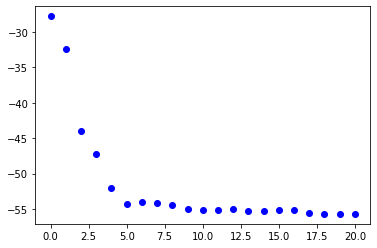

In [ ]:
plt.figure()
[plt.scatter(i,results.grammars[i].logLikelihood(program.infer(), program), c="blue") for i in range(len(results.grammars))]
plt.show()

---
## Notes

- Circuit Size is now fixed during enumeration
    - tasks know in advance the size (and only tasks with same signature can be done in one batch)
- No observational equivalence for tcircuit --> no repetition primitive can be used
    - at the moment it is not needed
    - task evaluation with timeout should then be reintroduced
- Warning in compression: Log priors differed during frontier combining
- compressor is slow when a lot of programs have been enumerated
- running DC from a notebook -> crashes when consolidating frontiers


GOALS:
- automatic discovery of useful blocks
- general technique to synthesize unitaries (+ restricted connectivity)


- Look at how the solution of a task evolves
- Try to generalize to larger depth and larger number of qubits
- TASK: average solving time / last time of solution / number of gates



- Limited connectivity
- For loops
- CLIFFORD circuits

- Add some continuous gate (i.e. phase(π/n) for small n) ?
- Should we add 3 qubit gates to our task list?
- Third set of gates: try with another set of gate to see how it changes? [Bootstrap learning via modular concept discovery](https://dash.harvard.edu/bitstream/handle/1/11223358/dechter-bootstrap-ijcai-2013.pdf?sequence=1&isAllowed=y)

Execution time explodes
Enumeration time is the most important 
How to go from circuit list to program
"Full" task likelihood?
What's the best metric to compare with full performance?
How's possible that not all full tasks can be re-enumerated with the full grammar?
    - It is very slow to check the solutions!
Run it longer
Running time with larger circuits? e.g. 4/5 qubits?
Are we pruning the primitive library?


CNOT 1 1 gets enumerated even though it raises an exception


In [ ]:
for i in range(len(dc.grammar.ENUMERATED_LIST)):
    np.testing.assert_allclose(tasks[i].target_circuit_evaluation,
                               circuit_to_mat(execute_program(dc.grammar.ENUMERATED_LIST[i],(0,1,2,(no_op(3))))))

QuantumCircuitException: Invalid selected qubit